We'll first segment the Herlev_dataset, single images, because we have mask images that can easily be used to validate the segmentation. 
Note: this notebook exists to visualize, create, and evaluate the pipeline, but at scale we will do this with scripts. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as stats
from os import listdir
from skimage import io, filters, color,exposure,feature,measure,segmentation
from scipy import ndimage
import cv2 
import imutils
import glob

Load in an image

In [127]:
image = plt.imread('../data/test.bmp')
image1 = plt.imread('../data/test1.bmp')
image2 = plt.imread('../data/test2.bmp')
image3 = plt.imread('../data/test3.bmp')
image4 = plt.imread('../data/test4.bmp')
image5 = plt.imread('../data/004_09.bmp')

1. Image preprocessing

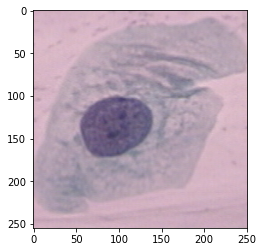

In [134]:
image = image4
plt.imshow(image)

In [135]:
# normalize image 

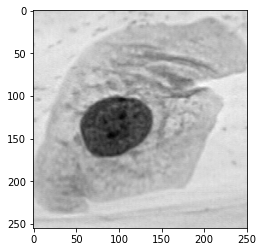

In [136]:
# convert to grayscale
gray_img = color.rgb2gray(image)
plt.imshow(gray_img,cmap='gray')

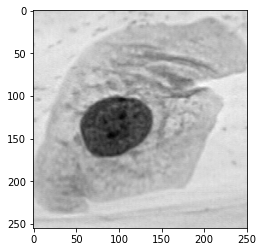

In [137]:
# apply median filter
filt_gray = ndimage.median_filter(gray_img,1)
# filt_gray = cv2.medianBlur(gray_img,5)
plt.imshow(filt_gray,cmap='gray')

In [138]:
# apply contrast local adaptive histogram (CLAHE) - I think that this approach doesn't work well for overlapping cells like this case
# filt2_gray = exposure.equalize_adapthist(filt_gray,kernel_size=100, clip_limit=2.0)
# plt.imshow(filt2_gray,cmap='gray')

#cv2 code - doesn't work 
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# filt2_gray = clahe.apply(filt_img)

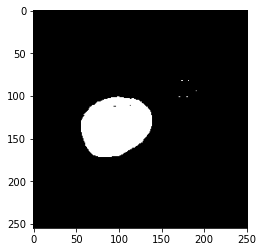

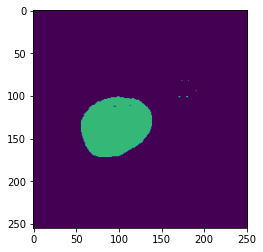

array([0, 1, 2, 3, 4, 5, 6])

In [139]:
# nuclei segmentation
threshold = filters.threshold_minimum(filt_gray)
nuclei = filt_gray < threshold
plt.imshow(nuclei, cmap=plt.cm.gray)
plt.show()
labeled_nuclei = measure.label(nuclei,background=0)
plt.imshow(labeled_nuclei)
plt.show()
np.unique(labeled_nuclei)

In [140]:
# get a table of region properties
props_table = measure.regionprops_table(labeled_nuclei,intensity_image = gray_img, properties=['area','centroid','major_axis_length','minor_axis_length','perimeter','eccentricity','solidity','max_intensity','min_intensity','bbox'])
nuclei_df = pd.DataFrame.from_dict(props_table)
nuclei_df = nuclei_df[nuclei_df['area']>300]
nuceli_df = nuclei_df[nuclei_df['perimeter']/nuclei_df['area']<0.25][nuclei_df['area']>300]
not nuclei_df.empty

True

In [141]:
nuclei_df['centroid'] = nuclei_df[['centroid-0', 'centroid-1']].values.tolist()

In [142]:
from scipy.spatial import distance as dist
img_ctr = [np.round(gray_img.shape[0]/2),np.round(gray_img.shape[1]/2)]
nuclei_df['ctr_score'] = nuclei_df['centroid'].apply(lambda x: dist.euclidean(x,img_ctr))
nuclei_df.sort_values(by=['ctr_score']).iloc[0]
# bbox0 = [0.15*gray_img.shape[0], 0.85*gray_img.shape[1]]
# bbox1 = [0.15*gray_img.shape[1], 0.85*gray_img.shape[1]]
# nuclei_df = nuclei_df[(nuclei_df['centroid-0']>bbox0[0])&(nuclei_df['centroid-0']<bbox0[1])]
# nuclei_df = nuclei_df[(nuclei_df['centroid-1']>bbox1[0])&(nuclei_df['centroid-1']<bbox1[1])]
# nuclei_df

area                      4561
centroid-0                 135
centroid-1                  95
major_axis_length      86.2788
minor_axis_length      67.6358
perimeter              272.936
eccentricity          0.620861
solidity              0.980439
max_intensity         0.471152
min_intensity         0.236973
bbox-0                     101
bbox-1                      56
bbox-2                     172
bbox-3                     139
centroid             [135, 95]
ctr_score              31.7805
Name: 3, dtype: object

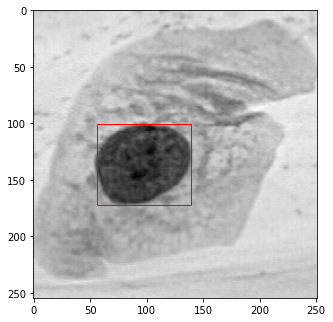

In [145]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(filt_gray,cmap='gray')
rect = plt.Rectangle((nuclei_df.iloc[0]['bbox-1'],nuclei_df.iloc[0]['bbox-0']),nuclei_df.iloc[0]['bbox-3']-nuclei_df.iloc[0]['bbox-1'],nuclei_df.iloc[0]['bbox-2']-nuclei_df.iloc[0]['bbox-0'],fill=False,color='r')
ax.add_patch(rect)